In [199]:
import torch
import torch.nn as nn
import requests
from torch import autograd
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [200]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [201]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(3200, 256)
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(-1, 3200)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [202]:
class CifarNetMod(nn.Module):
    def __init__(self, kron1, kron2, kron3):
        super(CifarNetMod, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(3200, 256)
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        
        self.fc1mod = kron1
        self.fc2mod = kron2
        self.fc3mod = kron3

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(-1, 3200)
        #x = self.relu(self.fc1(x))
        tmp = []
        for A, B in self.fc1mod:
            if not len(tmp):
                tmp = torch.kron(A.T, B.T)
            else:
                tmp += torch.kron(A.T, B.T)
        
        x = torch.matmul(x, tmp) + self.fc1.bias
        x = self.relu(x)
        
        x = self.dropout(x)
        
        #x = self.relu(self.fc2(x))
        tmp = []
        for A, B in self.fc2mod:
            if not len(tmp):
                tmp = torch.kron(A.T, B.T)
            else:
                tmp += torch.kron(A.T, B.T)
            
        x = torch.matmul(x, tmp) + self.fc2.bias
        x = self.relu(x)
        
        #x = self.fc3(x)
        tmp = []
        for A, B in self.fc3mod:
            if not len(tmp):
                tmp = torch.kron(A.T, B.T)
            else:
                tmp += torch.kron(A.T, B.T)

        x = torch.matmul(x, tmp) + self.fc3.bias

        return x

In [203]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

file_id = "1qrNvr3eLYjvbkVg5jY2sYA2rqK9XkTXs"
download_file_from_google_drive(file_id, "./cifar_checkpoint.pth")

model = CifarNet().to(device)
model.load_state_dict(torch.load("./cifar_checkpoint.pth", map_location="cpu"))

<All keys matched successfully>

In [204]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
%%time
matched = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        matched += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * matched // total} %')

Accuracy of the network on the 10000 test images: 68 %
CPU times: user 27.7 s, sys: 607 ms, total: 28.3 s
Wall time: 28.4 s


In [ ]:
model

CifarNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=3200, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [205]:
def R(matrix, p, q):
    n = matrix.shape[0] // p
    m = matrix.shape[1] // q
    assert n * p == matrix.shape[0]
    assert m * q == matrix.shape[1]

    r = torch.tensor([])
    for j in range(m):
        for i in range(n):
            M = matrix[i*p:(i+1)*p, j*q:(j+1)*q]
            M = M.T.flatten()
            #print(M)
            if not len(r):
                r = M
            else:
                r = torch.vstack((r, M))
            
    return r

In [206]:
def invR(vector, p, q):
    assert p*q == vector.shape[0]
    m = torch.tensor([])
    for i in range(q):
        V = vector[i*p:(i+1)*p]
        if not len(m):
            m = V.reshape(-1, 1)
        else:
            m = torch.hstack((m, V.reshape(-1, 1)))
            
    return m

In [207]:
def kron_factor(u, s, vt, rank, p, q, p_orig, q_orig):
    assert vt.shape[1] == p*q
    u_ = u[:, : rank]
    #print(rank, u_.shape)
    s_ = s[:rank]
    vt_ = vt[:rank, :]
    for i in range(rank):
        #print(u_[:,i].shape)
        #print(vt_[i,:].shape)
        A = invR(u_[:, i], p_orig // p, q_orig // q)
        B = invR(s[i] * vt_[i, :], p, q)
        yield A, B

In [210]:
fc1 = model.fc1.weight
fc2 = model.fc2.weight
fc3 = model.fc3.weight

In [ ]:
p1, q1 = 32, 32
p2, q2 = 32, 32
p3, q3 = 2, 32
r1 = fc1.shape[0] * fc1.shape[1] // (p1 * q1)
r2 = fc2.shape[0] * fc2.shape[1] // (p2 * q2)
r3 = fc3.shape[0] * fc3.shape[1] // (p3 * q3)

In [ ]:
part = 0.15

In [ ]:
krons = {0:[], 1:[], 2:[]}
p = {0:p1,1:p2,2:p3}
q = {0:q1,1:q2,2:q3}
r = {0:int(part * r1),1:int(part*r2),2:int(part*r3)}

In [ ]:
for i, fc in enumerate([fc1, fc2, fc3]):
    R_ = R(fc, p[i], q[i])
    u, s, vt = torch.linalg.svd(R_, full_matrices=False)
    for A,B in kron_factor(u, s, vt, r[i], p[i], q[i], fc.shape[0], fc.shape[1]):
        krons[i].append((A,B))

In [ ]:
modelmod = CifarNetMod(krons[0], krons[1], krons[2]).to(device)

In [ ]:
modelmod.load_state_dict(torch.load("./cifar_checkpoint.pth", map_location="cpu"))

<All keys matched successfully>

In [ ]:
%%time
matched = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        outputs = modelmod(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        matched += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * matched // total} %')

Accuracy of the network on the 10000 test images: 39 %
CPU times: user 44.4 s, sys: 1.78 s, total: 46.2 s
Wall time: 46.7 s


orig - 68% \ 27.7s \
0.8 rank - 68% 128s \
0.6 rank - 68% 103s \
0.4 rank - 67% 73s \
0.3 rank - 64% 61s \
0.2 rank - 56% 50s \
0.15 rank - 39% 44.4s \
0.1 rank - 27% 40s \

In [252]:
accuracy = [68, 68, 68, 67, 64, 56, 39, 27]
times = [27.7, 128, 103, 73, 61, 50, 44.4, 40]
names = [1.0, 0.8, 0.6, 0.4, 0.3, 0.2, 0.15, 0.1]

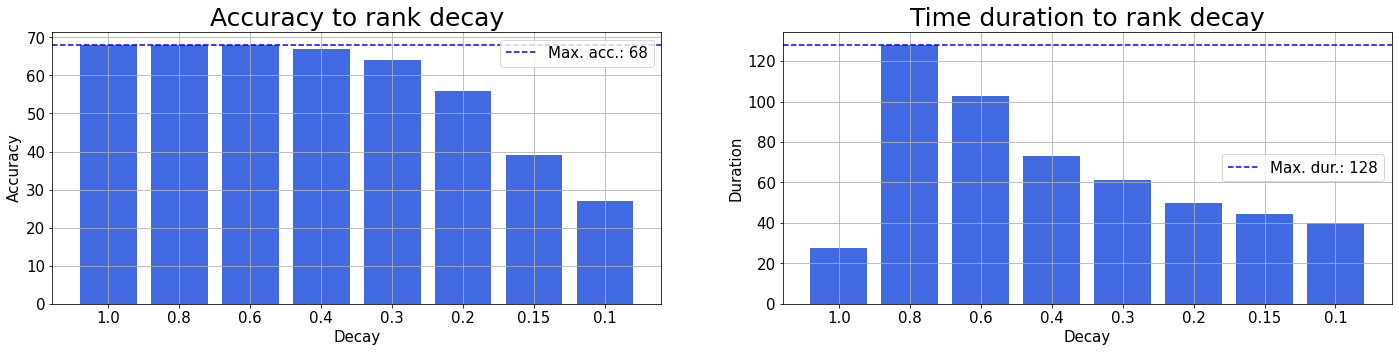

In [255]:
plt.figure(figsize=(24, 5))

ax = plt.subplot(121)
g = plt.bar(range(len(names)), accuracy, color='royalblue')

plt.axhline(y=max(accuracy), color='b', linestyle='--', label=f'Max. acc.: {max(accuracy)}')

plt.title('Accuracy to rank decay', fontsize=25)
plt.xlabel('Decay', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xticklabels([None]+names) 
plt.grid(True)
plt.legend(loc='best', fontsize=15)

ax = plt.subplot(122)
g = plt.bar(range(len(names)), times, color='royalblue')

plt.axhline(y=max(times), color='b', linestyle='--', label=f'Max. dur.: {max(times)}')

plt.title('Time duration to rank decay', fontsize=25)
plt.xlabel('Decay', fontsize=15)
plt.ylabel('Duration', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xticklabels([None]+names) 
plt.grid(True)
plt.legend(loc='best', fontsize=15)
plt.savefig('./time.png')
plt.show()

Shapeshifter part:

In [261]:
class CifarNetMod2(nn.Module):
    def __init__(self, kron1, size1, kron2, size2, kron3, size3):
        super(CifarNetMod2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(3200, 256)
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        
        self.fc1mod = kron1
        self.fc2mod = kron2
        self.fc3mod = kron3
        self.size1 = size1
        self.size2 = size2
        self.size3 = size3

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(-1, 3200)
        #x = self.relu(self.fc1(x))
        tmp = torch.transpose((self.fc1mod[0] @ self.fc1mod[1]).reshape(self.size1[0], self.size1[2],self.size1[1],self.size1[3]), 1, 2)
        tmp = tmp.reshape(-1,self.size1[2]*self.size1[3])
        x = x @ tmp.T + self.fc1.bias
        
        x = self.relu(x)
        
        x = self.dropout(x)
        
        #x = self.relu(self.fc2(x))
        tmp = torch.transpose((self.fc2mod[0] @ self.fc2mod[1]).reshape(self.size2[0], self.size2[2],self.size2[1],self.size2[3]), 1, 2)
        tmp = tmp.reshape(-1,self.size2[2]*self.size2[3])
        x = x @ tmp.T + self.fc2.bias
        
        x = self.relu(x)
        
        #x = self.fc3(x)
        tmp = torch.transpose((self.fc3mod[0] @ self.fc3mod[1]).reshape(self.size3[0], self.size3[2],self.size3[1],self.size3[3]), 1, 2)
        tmp = tmp.reshape(-1,self.size3[2]*self.size3[3])
        x = x @ tmp.T + self.fc3.bias
        

        return x

In [257]:
shapes1 = [16, 16, 50, 64]
shapes2 = [16, 16, 16, 16]
shapes3 = [2, 5, 16, 16]

In [258]:
F1 = torch.transpose(fc1.reshape(shapes1[0],shapes1[1],shapes1[2],shapes1[3]), 1, 2).reshape(shapes1[1]*shapes1[2],-1)
u, s, vt = torch.linalg.svd(F1, full_matrices=False)
A1 = u
B1 = s.reshape(-1, 1) * vt

In [259]:
F2 = torch.transpose(fc2.reshape(shapes2[0],shapes2[1],shapes2[2],shapes2[3]), 1, 2).reshape(shapes2[1]*shapes2[2],-1)
u, s, vt = torch.linalg.svd(F2, full_matrices=False)
A2 = u
B2 = s.reshape(-1, 1) * vt

In [262]:
F3 = torch.transpose(fc3.reshape(shapes3[0],shapes3[1],shapes3[2],shapes3[3]), 1, 2).reshape(shapes3[1]*shapes3[2],-1)
u, s, vt = torch.linalg.svd(F3, full_matrices=False)
A3 = u
B3 = s.reshape(-1, 1) * vt

In [291]:
newr1, newr2, newr3 = int(0.2*r1), int(0.2*r2), int(0.2*r3)

In [292]:
modelmod2 = CifarNetMod2([A1[:,:newr1], B1[:newr1, :]], shapes1,[A2[:,:newr2], B2[:newr2, :]], shapes2,[A3[:,:newr3], B3[:newr3, :]], shapes3)

In [293]:
modelmod2.load_state_dict(torch.load("./cifar_checkpoint.pth", map_location="cpu"))

<All keys matched successfully>

In [294]:
%%time
matched = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        outputs = modelmod2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        matched += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * matched // total} %')

Accuracy of the network on the 10000 test images: 46 %
CPU times: user 31.3 s, sys: 741 ms, total: 32 s
Wall time: 34.9 s


0.8 - 69% 33.9s \
0.6 - 68% 31.9s \
0.4 - 64% 29.5s \
0.3 - 61% 30.8\
0.2 - 46% 29.3s\
0.15 - 33% 28.7s\
0.1 - 21% 29.3

In [295]:
accuracy2 = [69, 68, 68, 64, 61, 46, 33, 21]
times2 = [27.7,33.9, 31.9, 29.5, 30.8, 29.3, 28.7, 29.3]
names2 = [1.0, 0.8, 0.6, 0.4, 0.3, 0.2, 0.15, 0.1]

In [297]:
random1 = torch.rand(1050, 1050)

In [303]:
loss = []
ranks = [1000, 900, 800, 600, 500, 300, 100]
for rrr in ranks:
    a_b = []
    R_ = R(random1, 30, 35)
    u, s, vt = torch.linalg.svd(R_, full_matrices=False)
    for A,B in kron_factor(u, s, vt, rrr, 30, 35, random1.shape[0], random1.shape[1]):
        a_b.append((A,B))

    tmp = []
    for A, B in a_b:
        if not len(tmp):
            tmp = torch.kron(A, B)
        else:
            tmp += torch.kron(A, B)
    loss.append(torch.linalg.norm(random1 - tmp))

In [310]:
shapes = [30, 35, 30, 35]

In [311]:
F = torch.transpose(random1.reshape(shapes[0],shapes[1],shapes[2],shapes[3]), 1, 2).reshape(shapes[1]*shapes[2],-1)
u, s, vt = torch.linalg.svd(F, full_matrices=False)
A = u
B = s.reshape(-1, 1) * vt

In [312]:
loss2 = []
for rrr in ranks:
    A_ = A[:,:rrr]
    B_ = B[:rrr, :]
    tmp = torch.transpose((A_ @ B_).reshape(shapes[0], shapes[2], shapes[1], shapes[3]), 1, 2)
    tmp = tmp.reshape(-1, shapes[2]* shapes[3])
    loss2.append(torch.linalg.norm(random1 - tmp))

In [313]:
loss2

[tensor(2.8029),
 tensor(14.8371),
 tensor(31.9333),
 tensor(78.1267),
 tensor(106.2426),
 tensor(172.3103),
 tensor(253.5123)]

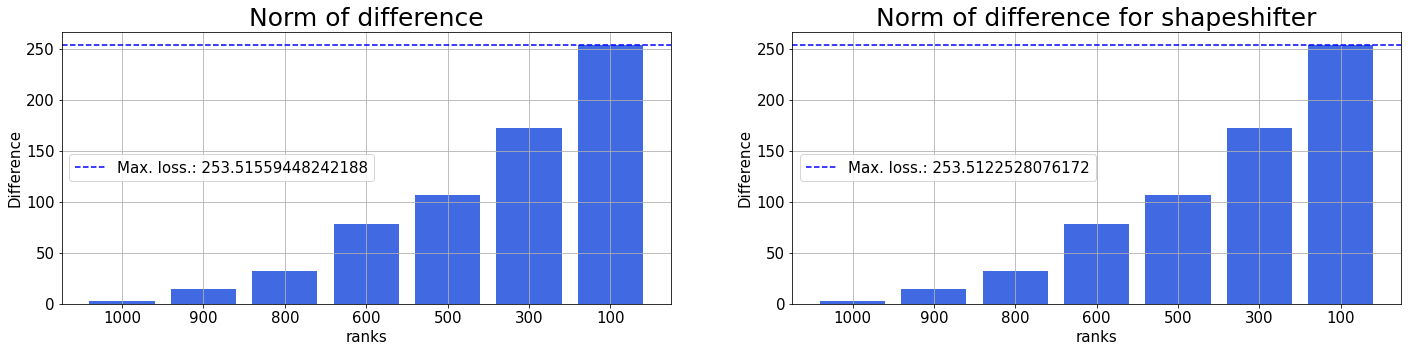

In [317]:
plt.figure(figsize=(24, 5))

ax = plt.subplot(121)
g = plt.bar(range(len(loss)), loss, color='royalblue')

plt.axhline(y=max(loss), color='b', linestyle='--', label=f'Max. loss.: {max(loss)}')

plt.title('Norm of difference', fontsize=25)
plt.xlabel('ranks', fontsize=15)
plt.ylabel('Difference', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xticklabels([None]+ranks) 
plt.grid(True)
plt.legend(loc='best', fontsize=15)

ax = plt.subplot(122)
g = plt.bar(range(len(loss2)), loss2, color='royalblue')

plt.axhline(y=max(loss2), color='b', linestyle='--', label=f'Max. loss.: {max(loss2)}')

plt.title('Norm of difference for shapeshifter', fontsize=25)
plt.xlabel('ranks', fontsize=15)
plt.ylabel('Difference', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xticklabels([None]+ranks) 
plt.grid(True)
plt.legend(loc='best', fontsize=15)
plt.savefig('./losses.png')
plt.show()